In [1]:
from modeling_lstm_seq2seq import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import MultiplicativeLR
from torch.utils.data import DataLoader
from tqdm import tqdm

from datasets import load_dataset
from torchtext.data.utils import get_tokenizer
import torchtext
import pickle

c:\Kyode\clg\DL_Assignments\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# import os

# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
NUM_EPOCHS = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 32
MAX_LENGTH = 128

LSTM_LOCAL_PATH = "local_lstm"
LSTM_GLOBAL_PATH = "global_lstm"
LSTM_PATH = "classic_lstm"

In [4]:
train_ds = load_dataset('wmt16', 'de-en', split='train[:1%]')
val_ds = load_dataset('wmt16', 'de-en', split='validation')
test_ds = load_dataset('wmt16', 'de-en', split='test')

Found cached dataset wmt16 (C:/Users/gener/.cache/huggingface/datasets/wmt16/de-en/1.0.0/746749a11d25c02058042da7502d973ff410e73457f3d305fc1177dc0e8c4227)
Found cached dataset wmt16 (C:/Users/gener/.cache/huggingface/datasets/wmt16/de-en/1.0.0/746749a11d25c02058042da7502d973ff410e73457f3d305fc1177dc0e8c4227)
Found cached dataset wmt16 (C:/Users/gener/.cache/huggingface/datasets/wmt16/de-en/1.0.0/746749a11d25c02058042da7502d973ff410e73457f3d305fc1177dc0e8c4227)


In [5]:
new = train_ds[:len(train_ds)//2]

In [6]:
train_ds = train_ds.train_test_split(test_size = 0.5)["train"]

In [7]:
de_tokenizer = get_tokenizer('spacy', language='de')
en_tokenizer = get_tokenizer('spacy', language='en')

c:\Kyode\clg\DL_Assignments\venv\lib\site-packages\torchtext\data\utils.py:105: UserWarning: Spacy model "de" could not be loaded, trying "de_core_news_sm" instead
  warnings.warn(
c:\Kyode\clg\DL_Assignments\venv\lib\site-packages\torchtext\data\utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


In [8]:
def tokenize_de(text):
    return [tok for tok in de_tokenizer(text)]

def tokenize_en(text):
    return [tok for tok in en_tokenizer(text)]

In [9]:
tokenized_train_eng = [tokenize_en(text['en']) for text in tqdm(train_ds['translation'])]
tokenized_train_ger = [tokenize_de(text['de']) for text in tqdm(train_ds['translation'])]

100%|██████████| 22744/22744 [00:03<00:00, 7444.48it/s]


In [10]:
tokenized_val_eng = [tokenize_en(text['en']) for text in tqdm(val_ds['translation'])]
tokenized_val_ger = [tokenize_de(text['de']) for text in tqdm(val_ds['translation'])]

100%|██████████| 2169/2169 [00:00<00:00, 6340.66it/s]


In [16]:
# create a vocabulary of the training samples for only the top 50000 most common words without torchtext

eng_vocab = {}
ger_vocab = {}

for text in tqdm(tokenized_train_eng):
    for word in text:
        if word in eng_vocab:
            eng_vocab[word] += 1
        else:
            eng_vocab[word] = 1

for text in tqdm(tokenized_train_ger):
    for word in text:
        if word in ger_vocab:
            ger_vocab[word] += 1
        else:
            ger_vocab[word] = 1

100%|██████████| 22744/22744 [00:00<00:00, 70932.38it/s]


In [17]:
eng_vocab = {k: v for k, v in sorted(eng_vocab.items(), key=lambda item: item[1], reverse=True)}
ger_vocab = {k: v for k, v in sorted(ger_vocab.items(), key=lambda item: item[1], reverse=True)}

In [18]:
eng_vocab = dict(list(eng_vocab.items())[:50000])
ger_vocab = dict(list(ger_vocab.items())[:50000])

eng_vocab = {k: i+2 for i, k in enumerate(eng_vocab.keys())}
ger_vocab = {k: i+2 for i, k in enumerate(ger_vocab.keys())}

eng_vocab['<unk>'] = 0
ger_vocab['<unk>'] = 0

eng_vocab['<eos>'] = 1
ger_vocab['<eos>'] = 1

eng_vocab['<pad>'] = 0
ger_vocab['<pad>'] = 0

In [11]:
def pad_seq(seq, max_length):
    if len(seq)>max_length:
        return seq[:max_length-1] + ['<eos>']
    elif len(seq) == max_length:
        return seq
    seq += ["<pad>" for i in range(max_length - len(seq))]
    return seq

In [19]:
tokenized_train_eng = [pad_seq(text + ['<eos>'], MAX_LENGTH) for text in tqdm(tokenized_train_eng)]
tokenized_train_ger = [pad_seq(text + ['<eos>'], MAX_LENGTH) for text in tqdm(tokenized_train_ger)]

tokenized_val_eng = [pad_seq(text + ['<eos>'], MAX_LENGTH) for text in tqdm(tokenized_val_eng)]
tokenized_val_ger = [pad_seq(text + ['<eos>'], MAX_LENGTH) for text in tqdm(tokenized_val_ger)]

100%|██████████| 2169/2169 [00:00<00:00, 142490.45it/s]


In [12]:
def encode_eng(text):
    encoded = []
    for token in text:
        try:
            encoded.append(eng_vocab[token])
        except:
            encoded.append(eng_vocab['<unk>'])
    return encoded

def encode_ger(text):
    encoded = []
    for token in text:
        try:
            encoded.append(ger_vocab[token])
        except:
            encoded.append(ger_vocab['<unk>'])
    return encoded

In [21]:
encoded_train_eng = [encode_eng(text) for text in tqdm(tokenized_train_eng)]
encoded_train_ger = [encode_ger(text) for text in tqdm(tokenized_train_ger)]

100%|██████████| 22744/22744 [00:00<00:00, 49663.94it/s]


In [22]:
encoded_val_eng = [encode_eng(text) for text in tqdm(tokenized_val_eng)]
encoded_val_ger = [encode_ger(text) for text in tqdm(tokenized_val_ger)]

100%|██████████| 2169/2169 [00:00<00:00, 50435.45it/s]


In [23]:
tokenized_train_dataloader = DataLoader(list(zip(encoded_train_eng, encoded_train_ger)), batch_size=BATCH_SIZE, shuffle=True)
tokenized_val_dataloader = DataLoader(list(zip(encoded_val_eng, encoded_val_ger)), batch_size=BATCH_SIZE, shuffle=True)

In [13]:
with open("local_lstm/eng_vocab.pkl", "rb") as file:
    eng_vocab = pickle.load(file)

with open("local_lstm/ger_vocab.pkl", "rb") as file:
    ger_vocab = pickle.load(file)

In [14]:
config = Config(
    input_size=len(ger_vocab),
    embedding_size=1000,
    hidden_size=1000,
    num_layers=4,
    vocab_size=len(ger_vocab),
    dropout=0.2,
    device="cuda",
    max_length=MAX_LENGTH,
)

In [25]:
model = LSTMSeq2Seq(config, attention = True, alignment = "global", scoring_function = "general")
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [26]:
model.to(config.device)

LSTMSeq2Seq(
  (encoder): LSTMEncoder(
    (embedding): Embedding(35353, 1000)
    (lstm): LSTM(1000, 1000, num_layers=4, batch_first=True, dropout=0.2)
  )
  (decoder): LSTMDecoder(
    (embedding): Embedding(35353, 1000)
    (lstm): LSTM(1000, 1000, num_layers=4, batch_first=True, dropout=0.2)
    (attention): Attention(
      (W): Linear(in_features=1000, out_features=1000, bias=False)
    )
  )
  (lm_head): Linear(in_features=2000, out_features=35353, bias=True)
)

In [30]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    for batch in tqdm(dataloader):
        src = torch.stack(batch[0]).to(torch.int64).to(device)
        trg = torch.stack(batch[1]).to(torch.int64).to(device)
        src = src.transpose(0, 1)
        trg = trg.transpose(0, 1)

        optimizer.zero_grad()
        
        output = model(src, trg)
        # output = output[1:].view(-1, output.shape[2])
        # trg = trg[1:].view(-1)
        # output = output.max(dim = 2)

        output = output.permute(0, 2, 1)

        loss = criterion(output, trg)

        for name, param in model.named_parameters():
            param.retain_grad()
            # print(name, param.grad)

        loss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        epoch_loss += loss.item()
    return model, optimizer, epoch_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch in tqdm(dataloader):
            src = torch.stack(batch[0]).to(torch.int64).to(device)
            trg = torch.stack(batch[1]).to(torch.int64).to(device)
            output = model(src, trg, 0)
            # output = output[1:].view(-1, output.shape[2])
            # trg = trg[1:].view(-1)
            output = output.permute(0, 2, 1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

In [31]:
train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):
    model, optimizer, train_loss = train(model, tokenized_train_dataloader, optimizer, criterion, config.device)
    val_loss = evaluate(model, tokenized_val_dataloader, criterion, config.device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)

100%|██████████| 68/68 [00:32<00:00,  2.11it/s]

Epoch: 01
	Train Loss: 10.410
	 Val. Loss: 10.406


In [34]:
# torch.save({
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#     },
#     LSTM_GLOBAL_PATH + "/model.pt"
# )
# with open(LSTM_GLOBAL_PATH + "/eng_vocab.pkl", "wb+") as f:
#     pickle.dump(eng_vocab, f)

# with open(LSTM_GLOBAL_PATH + "/ger_vocab.pkl", "wb+") as f:
#     pickle.dump(ger_vocab, f)

In [15]:
model = LSTMSeq2Seq(config, attention = True, alignment = "local-m", scoring_function = "general")
ckpt = torch.load(LSTM_LOCAL_PATH + "/model.pt")
model.load_state_dict(ckpt['model_state_dict'])

<All keys matched successfully>

In [16]:
model.eval()

LSTMSeq2Seq(
  (encoder): LSTMEncoder(
    (embedding): Embedding(35285, 1000)
    (lstm): LSTM(1000, 1000, num_layers=4, batch_first=True, dropout=0.2)
  )
  (decoder): LSTMDecoder(
    (embedding): Embedding(35285, 1000)
    (lstm): LSTM(1000, 1000, num_layers=4, batch_first=True, dropout=0.2)
    (attention): Attention(
      (W): Linear(in_features=1000, out_features=1000, bias=False)
      (W_p): Linear(in_features=1000, out_features=1000, bias=False)
      (v_p): Linear(in_features=1000, out_features=1, bias=False)
    )
  )
  (lm_head): Linear(in_features=2000, out_features=35285, bias=True)
)

In [17]:
import evaluate
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

In [18]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(preds, labels):
    if isinstance(preds, tuple):
        preds = preds[0]

    print(preds, labels)
    
    decoded_preds, decoded_labels = postprocess_text(preds, labels)

    bleu_1 = bleu.compute(predictions=decoded_preds, references=decoded_labels, max_order=1)
    bleu_2 = bleu.compute(predictions=decoded_preds, references=decoded_labels, max_order=2)
    rouge_l = rouge.compute(predictions=decoded_preds, references=decoded_labels, rouge_types=["rougeL"])
    result = {"bleu_1": bleu_1["bleu"], "bleu_2": bleu_2["bleu"], "rouge_l": rouge_l["rougeL"]}

    return result

In [19]:
tokenized_test_eng = [tokenize_en(text['en']) for text in tqdm(test_ds['translation'])]
tokenized_test_ger = [tokenize_de(text['de']) for text in tqdm(test_ds['translation'])]

tokenized_test_eng = [pad_seq(text + ['<eos>'], MAX_LENGTH) for text in tqdm(tokenized_test_eng)]
tokenized_test_ger = [pad_seq(text + ['<eos>'], MAX_LENGTH) for text in tqdm(tokenized_test_ger)]

encoded_test_eng = [encode_eng(text) for text in tqdm(tokenized_test_eng)]
encoded_test_ger = [encode_ger(text) for text in tqdm(tokenized_test_ger)]

tokenized_test_dataloader = DataLoader(list(zip(encoded_test_eng, encoded_test_ger)), batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 2999/2999 [00:00<00:00, 56340.36it/s]


In [20]:
eng_idx2word = {v: k for k, v in eng_vocab.items()}
ger_idx2word = {v: k for k, v in ger_vocab.items()}

In [21]:
model = model.cuda()

In [22]:
bleu_scores = []
rouge_scores = []

decoded_sent = []
trg_sent = []

with torch.no_grad():
    for batch in tqdm(tokenized_test_dataloader):
        src = torch.stack(batch[0]).to(torch.int64).to(config.device)
        trg = torch.stack(batch[1]).to(torch.int64).to(config.device)
        src = src.transpose(0, 1)
        trg = trg.transpose(0, 1)
        output = model(src, trg, 0)
        for i in range(output.shape[0]):
            decoded_tokens = output[i].argmax(dim = 1)
            decoded_sent.append(' '.join([ger_idx2word[i.item()] for i in decoded_tokens]))
            trg_sent.append([' '.join([ger_idx2word[i.item()] for i in trg[i]])])

100%|██████████| 94/94 [27:13<00:00, 17.38s/it]


In [23]:
bleu_1 = bleu.compute(predictions=decoded_sent, references=trg_sent, max_order=1)
bleu_2 = bleu.compute(predictions=decoded_sent, references=trg_sent, max_order=2)
rouge_l = rouge.compute(predictions=decoded_sent, references=trg_sent, rouge_types=["rougeL"])

In [24]:
bleu_1["bleu"], bleu_2["bleu"], rouge_l['rougeL']

(0.006032885525274752, 0.0043725414159150105, 0.015717834780275247)

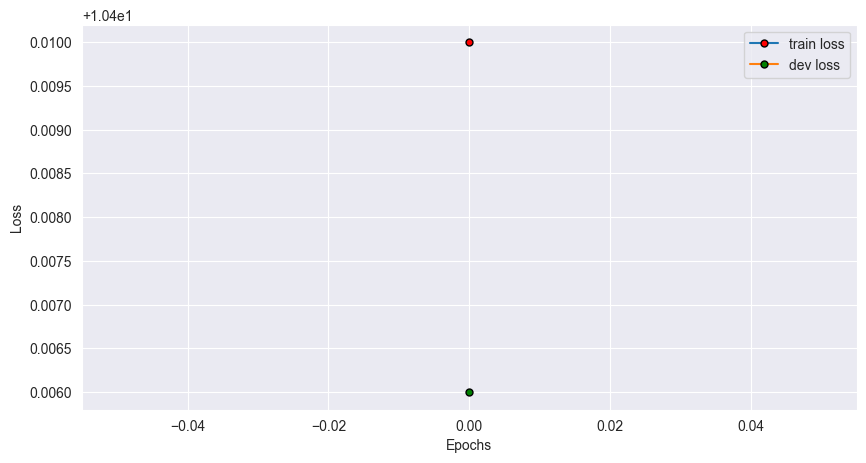

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_loss(train_loss, dev_loss):
    sns.set_style("darkgrid")
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, marker='o', markersize=5, markerfacecolor='r', markeredgecolor='k', label="train loss")
    plt.plot(dev_loss, marker='o', markersize=5, markerfacecolor='g', markeredgecolor='k', label="dev loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_loss(train_losses, val_losses)